### Object detection with Localisation using YOLO Algorithm

In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


## 1 - Information 

We have 80 classes that we want YOLO to recognize, we can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0.Here, I used the latter one

Because the YOLO model is very computationally expensive to train,I will load pre-trained weights to use. 

### 2- Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

We will use 5 anchor boxes. So , think of YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).


Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes). 
- Color that grid cell according to what object that grid cell considers the most likely.

### 2.2 - Filtering with a threshold on class scores

I m going to apply a first filter by thresholding  to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.


In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
  
    box_scores = box_confidence*box_class_probs

    box_classes = K.argmax(box_scores,axis=-1)
    box_class_scores = K.max(box_scores,axis=-1)

    filtering_mask = box_class_scores >= threshold

    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)

    
    return scores, boxes, classes

### Intersection over Union


In [4]:
def iou(box1, box2):
   
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area =max((xi2-xi1),0)*max((yi2-yi1),0)

    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    union_area = box1_area+box2_area-inter_area

    iou = inter_area/union_area
 
    
    return iou

Algo will give us many boxes it find and  We like to filter the algorithm's output down to a much smaller number of detected objects. To do so, we will use non-max suppression: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.

To implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute its overlap with all other boxes, and remove boxes that overlap it more than `iou_threshold`.
3. Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.


In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
   
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    

    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)

    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)

    
    return scores, boxes, classes

### 2.4 Wrapping up the filtering
Function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the above functions.


YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6)
    
    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5)
    
    
    return scores, boxes, classes

## 3 - YOLO pretrained model on images

In this part,  I am  going to use a pretrained model and test it on the car detection dataset.

In [7]:
sess = K.get_session()

### 3.1 - Defining classes, anchors and image shape.

We are trying to detect 80 classes, and are using 5 anchor boxes. We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt".

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [8]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

### 3.2 - Loading a pretrained model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. we are going to load an existing pretrained Keras YOLO model stored in "yolo.h5".
yolo.h5 can be downloaded ,easily.

In [9]:
yolo_model = load_model("model_data/yolo.h5")

/opt/conda/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

### 3.3 - Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. 

In [11]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

You added `yolo_outputs` to your graph. This set of 4 tensors is ready to be used as input by your `yolo_eval` function.

### 3.4 - Filtering boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. You're now ready to perform filtering and select only the best boxes. Lets now call `yolo_eval`, which you had previously implemented, to do this. 

In [12]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

### 3.5 - Run the graph on an image

Let the fun begin. You have created a (`sess`) graph that can be summarized as follows:

1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>


In [11]:
def predict(sess, image_file):
  
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))


    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    image.save(os.path.join("out", image_file), quality=90)
    
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    #plt.imshow(output_image)
    
    return out_scores, out_boxes, out_classes,output_image

#### Testing on the images

Found 2 boxes for p5.jpg
person 0.85 (405, 126) (737, 593)
motorbike 0.90 (142, 268) (1003, 657)


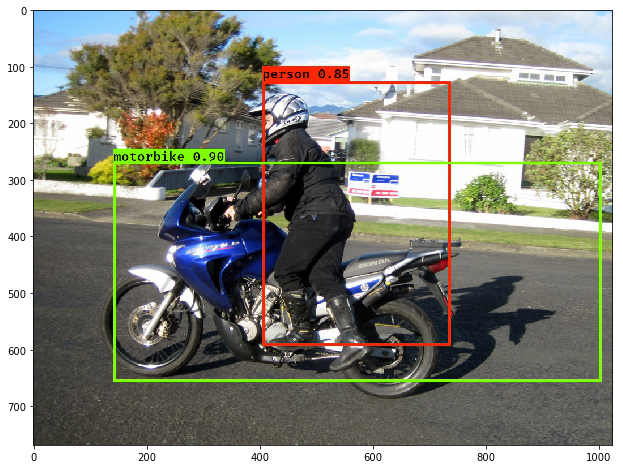

In [14]:
out_scores, out_boxes, out_classes,output_image = predict(sess, "p5.jpg")
plt.figure(figsize=(13,8))
plt.imshow(output_image)
plt.show()

Found 5 boxes for t1.jpg
car 0.62 (195, 405) (290, 482)
person 0.63 (1168, 370) (1200, 501)
car 0.75 (618, 397) (1061, 551)
car 0.79 (272, 386) (506, 498)
car 0.91 (331, 396) (775, 579)


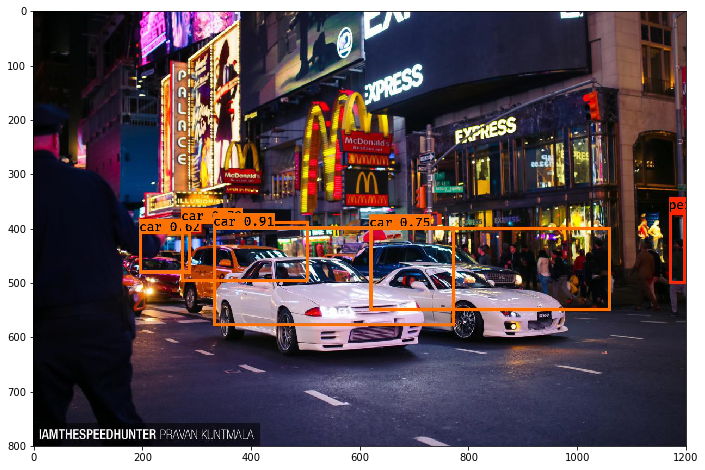

In [15]:
out_scores, out_boxes, out_classes,output_image = predict(sess, "t1.jpg")
plt.figure(figsize=(13,8))
plt.imshow(output_image)
plt.show()

Found 3 boxes for t2.jpg
truck 0.63 (327, 336) (579, 446)
car 0.65 (1138, 339) (1277, 402)
car 0.91 (769, 401) (1275, 720)


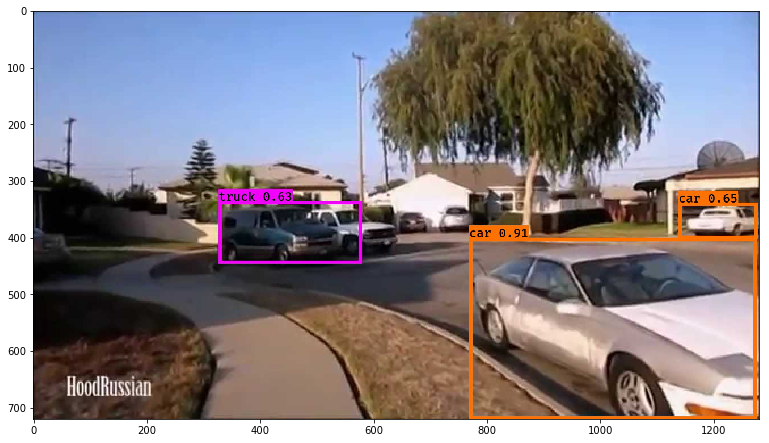

In [16]:
out_scores, out_boxes, out_classes,output_image = predict(sess, "t2.jpg")
plt.figure(figsize=(13,8))
plt.imshow(output_image)
plt.show()

### on my pic

Found 3 boxes for index.jpeg
cell phone 0.71 (767, 158) (846, 216)
laptop 0.88 (131, 384) (893, 713)
person 0.89 (593, 22) (1075, 550)


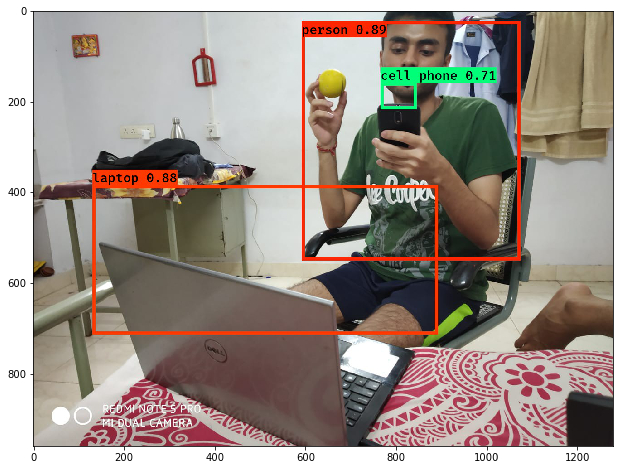

In [17]:
out_scores, out_boxes, out_classes ,output_image= predict(sess, "index.jpeg")
plt.figure(figsize=(15,8))
plt.imshow(output_image)
plt.show()

Found 6 boxes for test2.jpg
car 0.72 (1111, 380) (1277, 640)
car 0.76 (485, 321) (686, 448)
car 0.80 (97, 357) (406, 583)
car 0.81 (1040, 319) (1274, 502)
car 0.82 (280, 338) (509, 512)
car 0.87 (5, 368) (246, 662)


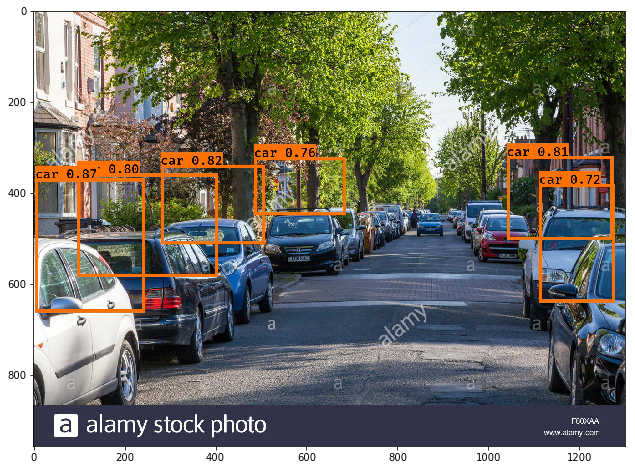

Found 5 boxes for test3.jpg
car 0.68 (83, 341) (173, 402)
car 0.70 (0, 339) (70, 439)
person 0.72 (324, 323) (377, 450)
person 0.80 (621, 302) (709, 516)
car 0.80 (1014, 341) (1200, 509)


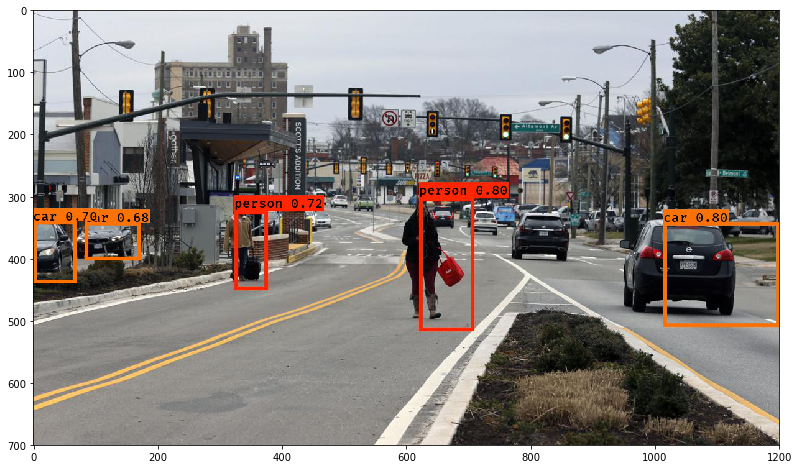

Found 5 boxes for test4.jpg
person 0.63 (440, 433) (580, 646)
person 0.67 (1093, 402) (1273, 685)
sports ball 0.71 (327, 344) (405, 404)
person 0.76 (503, 76) (1210, 718)
tennis racket 0.83 (51, 334) (583, 531)


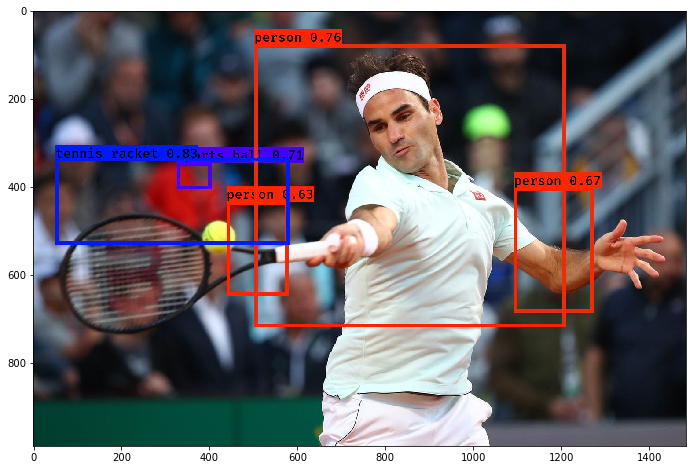

Found 8 boxes for test5.jpg
cup 0.61 (329, 428) (402, 481)
person 0.64 (617, 312) (640, 481)
cup 0.67 (562, 405) (620, 465)
diningtable 0.73 (158, 408) (640, 481)
person 0.74 (129, 193) (357, 481)
refrigerator 0.78 (522, 172) (640, 454)
person 0.79 (0, 302) (499, 481)
person 0.85 (681, 39) (640, 481)


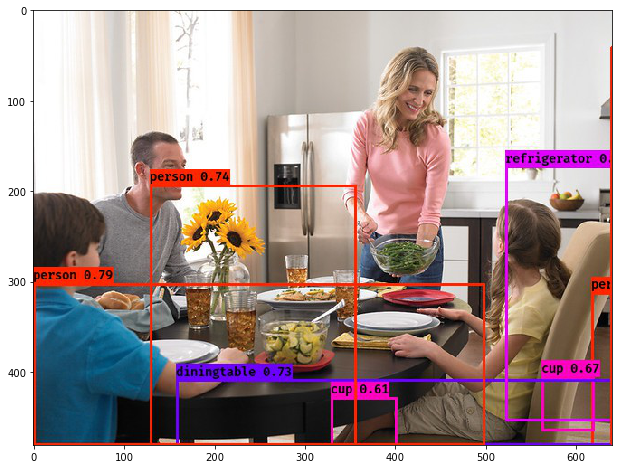

In [18]:
for i in range(2,6):
    img="test"+str(i)+".jpg"
    out_scores, out_boxes, out_classes,output_image = predict(sess, img)
    plt.figure(figsize=(15,8))
    plt.imshow(output_image)
    plt.show()
   
